In [78]:
import numpy as np 
import networkx as nx

import copy

from scipy.fft import dct
from scipy.linalg import fractional_matrix_power
from group_lasso import GroupLasso
from scipy.cluster.hierarchy import dendrogram

from matplotlib import pyplot as plt
from itertools import combinations  
from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")

# Step 1 - Synthetic graph aligning the subspaces
## Finding isometries between orthonormal basis

In [2]:
class SyntheticGrassmanGraph:
    def __init__(
            self, 
            V, 
            d, 
            basis,
            seed,
            mode,
            E0 = None,
            tau = None
    ):
        '''
        A class implementing our graph model based on the alignment of linear vector subspaces
        Attributes:
            V: int ->           Number of nodes
            d: int ->           Nodes stalks dimension
            basis: np.array ->  A complete dictionary (we usually use DCT) for the stalk on the nodes (we consider R^d without loss of generality)
            seed: int ->        Random seed for reproducibility
            mode: str ->        Mode for the generation of the graph, 
                                either "boolean" if based on cardinality constrained programming 
                                or "geometric" if based on thresholding the post-alignemnt distance
            E0: int ->          Prior assumption on the number of edges
            tau: float ->       Threshold for the geometric graph
        Methods:
            subpaceAssignment   Randomly assign to each node a linear subspace of R^d with dimension sampled uniformly at random between 1 and d
            Procrustes          Compute the orthogonal Procrustes solution to the alignment problem ||F_uD_u - F_vD_v||_F^2
            alignment           Perform the alignment between each pair of subspaces
            inference           Carries out a graph based on one of the two mode as a set of edges
        '''

        assert V >= d
        assert mode in ['Geometric','Boolean']

        self.V = V
        self.d = d
        self.E0 = E0
        self.tau = tau
        self.basis = basis
        self.seed = seed
        self.mode = mode

        self.subSpaceAssignment()
        self.alignment()

    def subSpaceAssignment(self):
        
        # Randomly generating subspaces spanned by subsets of the shared basis
        self.SS = {v: np.random.choice(self.d, np.random.choice(np.arange(1,self.d), 1), replace = False) for v in range(self.V)}

        # Preallocating basis for such subspaces
        self.DS = {
            v: np.hstack([self.basis[:,self.SS[v]], np.zeros((self.d, self.d - len(self.SS[v])))])
            for v in range(self.V)
        }
        
    def Procrustes(self, u, v):
        
        D_u = self.DS[u]
        D_v = self.DS[v]

        # Procrustes solution to the alignment problem is based on SVD of the cross product between the basis of the two spaces to be aligned
        X, _, Y = np.linalg.svd(D_v @ D_u.T)
        F_u = X @ Y
        F_v = np.eye(self.d)

        return F_u, F_v, D_u, D_v
    
    def alignment(self):

        # Perform the alignment and store the distance after this operation
        self.dists = {}
        self.Fs = {edge: {
            edge[0]: None, 
            edge[1]: None
        } for edge in list(combinations(range(self.V), 2))}
        
        for (u,v) in list(combinations(range(self.V), 2)):
            F_u, F_v, D_u, D_v = self.Procrustes(u,v)
            self.Fs[(u,v)][u] = F_u
            self.Fs[(u,v)][v] = F_v
            self.dists[(u,v)] = np.linalg.norm(F_u @ D_u - F_v @ D_v)
    
    def inference(self):
        
        # Edge-set-cardinality based graph -> Sort the Dirichlet energies and keep the first E0
        if self.mode == 'Boolean':
            sorted_edges = sorted(self.dists.items(), key=lambda x:x[1])
            return list(map(lambda x: x[0], sorted_edges[:self.E0]))

        # Alignment-distance-thresholding based graph -> Keep the subset of edges whose Dirichlet energy is below the threshold tau
        if self.mode == 'Geometric':
            filtered_edges = filter(lambda x: x[1] <= self.tau, self.dists.items())
            return list(map(lambda x: x[0], filtered_edges))

In [3]:
# Example utilization

d = 64
B = dct(np.eye(d), axis=0, norm='ortho').T
G = SyntheticGrassmanGraph(64, 64, B, 42, 'Boolean', 100, 0)

# Step 2a - Generating signals showing local group sparsity without noise

In [4]:
class SyntheticSignals:
    def __init__(self, basis, V, d, seed, snaps):
        '''
        A class for generating possibly noisy signals with a covariance structure lying on different linear subspaces
        Attributes:
            V: int ->               Number of nodes
            d: int ->               Nodes stalks dimension
            SNR: float ->           Signal-to-noise ratio (db)
            seed: int ->            Random seed for reproducibility
            snaps: int ->           Number of signals observed in each subspace
        Methods:
            subpaceAssignment       Randomly assign to each node a linear subspace of R^d with dimension sampled uniformly at random between 1 and d
            random_crosscov         Generates a random crosscovariance matrix with a specific block-sparsity pattern
            random_coefficients     Generates gaussian distributed coefficients for the sparse construction of signals 
            noise                   Generates noise with a given SNR
            normalize               Performs L2 normalization 
            signals_generation      Generates signals accordingly to precomputed basis and spectrum 
        '''

        self.basis = basis
        self.V = V
        self.d = d
        self.seed = seed
        self.snaps = snaps
        self.generated = False
        
        self.subspace_assignment()
        self.random_crosscov()
        self.random_coefficients()
                
    def subspace_assignment(self):

        self.SS = {v: np.random.choice(self.d, np.random.choice(np.arange(1,self.d), 1), replace = False) for v in range(self.V)}
        self.dims = {v:len(self.SS[v]) for v in range(self.V)}

    def random_crosscov(self, scale = 10):
        
        self.dim = np.sum(list(self.dims.values()))

        # Generate a random positive spectrum
        eigenvalues = np.random.exponential(scale, self.dim)

        # Use QR decomposition on a matrix with random entries to get an orthonormal basis
        Q, _ = np.linalg.qr(np.random.randn(self.dim, self.dim))

        # Build a covariance matrix using the computed spectrum and orthonormal basis
        self.C = Q @ np.diag(eigenvalues) @ Q.T
        '''
        self.Cs = {(u,v): None for (u,v) in list(combinations(range(self.V),2))}

        # Map all the blocks of the covariance matrix for further operations
        start_i = 0
        for i, di in list(self.dims.items()):
            start_j = start_i + di  # Upper triangular starts after the diagonal block
            for j, dj in list(self.dims.items())[i+1:]:
                end_i = start_i + di
                end_j = start_j + dj
                self.Cs[(i,j)] = self.C[start_i:end_i, start_j:end_j]
                start_j = end_j
            start_i += di
        '''

    def random_coefficients(self):
        
        # Generate a stack of all the coefficients leveraging the imposed covariance structure
        self.S = self.C @ np.random.randn(self.dim, self.snaps)

        # Map back all the coefficients ot each node
        self.coeffs = {v: None for v in range(self.V)}
        start = 0
        for v in range(self.V):
            end = start + self.dims[v]
            self.coeffs[v] = self.S[start:end, :]
            start = end
    
    def noise(self, signal, SNR):

        if SNR is None:
            return np.zeros_like(signal)

        signal_power = np.mean(np.square(signal), axis=0, keepdims=True)
        snr_linear = 10 ** (SNR / 10)
        noise_power = signal_power / snr_linear

        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
        return noise
    
    
    def normalize(self, signal):

        return signal / np.linalg.norm(signal, axis=0)
    
    def signals_generation(self, SNR):
        
        # Finally we leverage the structure we impose to generate signals
        np.random.seed(self.seed)
        self.signals = {
            node: (
                signal := self.normalize(self.basis[:,self.SS[node]] @ self.coeffs[node]))
             + self.noise(signal, SNR)
            for node in range(self.V)
        }

        self.generated = True
    
    def sparse_coder(self, alpha):

        def prox21_col(x):
                
            return ( 1 - alpha / (np.max([np.linalg.norm(x), alpha])) ) * x
        
        def prox21(X):

            X = np.apply_along_axis(prox21_col, axis = 1, arr = X)
            return X

        def ProxGradDescent(node, LR = 3e-3, MAXITER = 1000, eps = 1e-2):
            S = np.zeros((self.d, self.snaps))
            loss = np.inf

            for _ in range(MAXITER):
                # Gradient update: x_new = x_old + step_size * D^T (y - D * x_old)
                gradient = self.basis.T @ self.basis @ S - self.basis.T @ self.signals[node]
                S = S - LR * gradient
                
                # Hard thresholding: keep only the k largest entries
                S = prox21(S)
                
                temp = np.linalg.norm(self.signals[node] - self.basis @ S)
                if loss - temp < eps:
                    break
                else:
                    loss = temp
            return S
        
        if self.generated:
            coder = {v: np.zeros((self.d, self.snaps)) for v in range(self.V)}
            for node in range(self.V):
                coder[node] = ProxGradDescent(node)
            return coder
        else:
            return 'Before sparsifying you should generate signals :)'

In [5]:
# Example utilization
V = 64
d = 64
B = dct(np.eye(d), axis=0, norm='ortho').T
X = SyntheticSignals(B, V, d, 42, 100)

# Step 2b - Repeating the graph construction in a data driven way 

In [7]:
class DataDrivenGrassmanGraph:
    def __init__(
            self, 
            V, 
            d,
            X,
            basis,
            seed
    ):
        '''
        This class should implement the same idea of subspace alignment 
        but through a data-driven apoproach, i.e. using observed signals and not basis for subspaces (still under modeling phase)
        Attributes:
            V: int ->               Number of nodes
            d: int ->               Nodes stalks dimension
            X: SyntheticSignals ->  An instantiated object of the SyntheticSignals class
            seed: int ->            Random seed for reproducibility
            mode: str ->            Mode for the generation of the graph, 
                                    either "boolean" if based on cardinality constrained programming 
                                    or "geometric" if based on thresholding the post-alignemnt distance
            tau: float ->           Threshold for the geometric graph
        Methods:
            Procrustes              Compute the orthogonal Procrustes solution to the data-driven alignment problem ||F_u X_u - F_v X_v||_F^2
            alignment               Perform the alignment between each pair of subspaces
            inference               Carries out a graph based on one of the two mode as a set of edges
        '''

        self.V = V
        self.d = d

        self.X = X
        self.basis = basis
  
        self.seed = seed

    def Procrustes(self, u, v, codebook = None):
        if codebook is None:
            S_u = self.X.coeffs[u]
            S_v = self.X.coeffs[v]
            D_u = self.basis[:,self.X.SS[u]]
            D_v = self.basis[:,self.X.SS[v]]
            
        else:
            S_u = codebook[u]
            S_v = codebook[v]
            D_u = self.basis
            D_v = self.basis
            
        # We use the empirical cross covariance
        C_uv = S_u @ S_v.T / self.X.snaps

        X, _, Y = np.linalg.svd(D_u @ C_uv @ D_v.T, full_matrices=False)
        F_u = Y.T @ X.T
        F_v = np.eye(self.d)

        return F_u, F_v, D_u @ S_u, D_v @ S_v
    
    def alignment(self, codebook = None):
        
        self.pre_dists = {}
        self.post_dists = {}
        self.Fs = {edge: {
                    edge[0]: None, 
                    edge[1]: None
                } for edge in list(combinations(range(self.V), 2))}
                
        self.dims_diff = {}
        
        for (u,v) in list(combinations(range(self.V), 2)):
            F_u, F_v, S_u, S_v = self.Procrustes(u, v, codebook)
            self.pre_dists[(u,v)] = np.linalg.norm(S_u - S_v) ** 2 / self.X.snaps
            self.post_dists[(u,v)] = np.linalg.norm(F_u @ S_u - F_v @ S_v) ** 2 / self.X.snaps
            self.Fs[(u,v)][u] = F_u
            self.Fs[(u,v)][v] = F_v
            self.dims_diff[(u,v)] = np.abs(len(self.X.SS[u]) - len(self.X.SS[v]))
            
    def inference(self):
        
        return {
            'Pre': list(sorted(self.pre_dists.items(), key=lambda x:x[1])),
            'Post': list(sorted(self.post_dists.items(), key=lambda x:x[1]))
        }


In [7]:
d = 64
V = 64
B = dct(np.eye(d), axis=0, norm='ortho').T

X = SyntheticSignals(B, V, d, 42, 1000)

G = DataDrivenGrassmanGraph(V, d, X, B, 42)
G.alignment()

___

# Step 3 - Parametrize the construction wrt the SNR 


- Run a sparse coder on each node to get rid of the noise
- Run the inferential procedure

In [8]:
SNRs = [-15,-5,5,15]

In [13]:
SNRs = [5,25]
alphas = [1e-4, 5e-4,1e-3]

codebook = {
    alpha: {
        SNR: None for SNR in SNRs
    } for alpha in alphas
}

In [14]:
d = 64
V = 64
B = dct(np.eye(d), axis=0, norm='ortho').T

In [15]:
X = SyntheticSignals(B, V, d, 42, 100)

In [16]:
for alpha in alphas:
    for SNR in tqdm(SNRs):
        X.signals_generation(SNR)
        codebook[alpha][SNR] = X.sparse_coder(alpha)

100%|██████████| 2/2 [00:08<00:00,  4.28s/it]


In [17]:
G = DataDrivenGrassmanGraph(V, d, X, B, 42)

In [18]:
dists = {
    alpha: {
        SNR: None for SNR in SNRs
    } for alpha in alphas
}

for alpha in alphas:
    for SNR in SNRs:
        G.alignment(codebook[alpha][SNR])
        dists[alpha][SNR] = copy.copy(G.inference())

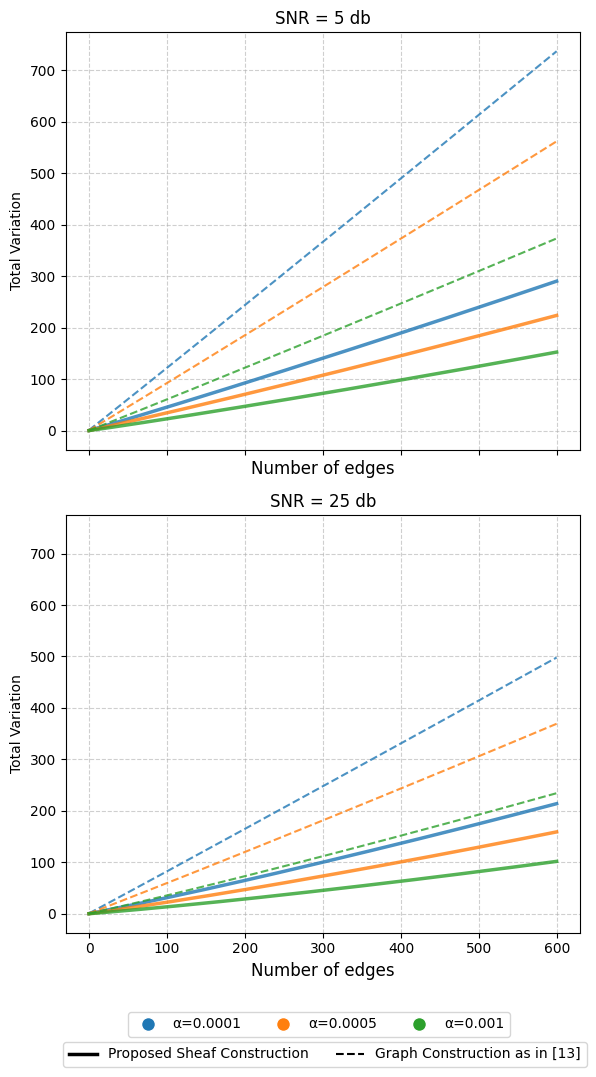

In [19]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define a color map for the alphas
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Determine grid layout (2x1) for subplots
rows, cols = 2, 1
fig, axes = plt.subplots(rows, cols, figsize=(6, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten for easier indexing

# Iterate over SNRs and plot on subplots
for i, SNR in enumerate(SNRs):
    ax = axes[i]  # Current subplot
    for j, alpha in enumerate(alphas):
        TVs_pre = []
        TVs_post = []

        TVS = dists[alpha][SNR]

        # Calculate cumulative sums for Pre and Post
        for E0 in range(1, len(list(combinations(range(V), 2))))[:600]:
            TVs_pre.append(np.sum([TVS['Pre'][k][1] for k in range(0, E0)]))
            TVs_post.append(np.sum([TVS['Post'][k][1] for k in range(0, E0)]))

        # Plot Pre (dashed line) and Post (solid, thicker line) with the same color
        ax.plot(
            TVs_pre,
            color=colors[j],
            linestyle='--',
            linewidth=1.5,
            alpha=0.8,
        )
        ax.plot(
            TVs_post,
            color=colors[j],
            linestyle='-',
            linewidth=2.5,  # Thicker line for Post
            alpha=0.8,
        )

    # Add dashed grid, title, and labels
    ax.grid(linestyle='--', alpha=0.6)
    ax.set_title(f'SNR = {SNR} db')
    ax.set_ylabel('Total Variation')
    ax.set_xlabel('Number of edges', fontsize=12)

# Add common x-label, y-label
plt.xlabel('Number of edges', fontsize=12)
plt.tight_layout()

# Create custom legend handles for colors (dots)
handles_color = []
for j, alpha in enumerate(alphas):
    handles_color.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[j], markersize=10))

# Create custom legend handles for line styles (Proposed/SoA)
handles_lines = [
    Line2D([0], [0], linestyle='-', color='black', linewidth=2.5),  # Proposed
    Line2D([0], [0], linestyle='--', color='black', linewidth=1.5),  # SoA
]

# Define the labels for the color (alpha) and line styles
labels_color = [f'α={alpha}' for alpha in alphas]  # Dots for alpha values
labels_lines = ['Proposed Sheaf Construction', 'Graph Construction as in [13]']  # Lines for Proposed and SoA

# Add the first legend (colors for alphas)
fig.legend(
    handles_color, 
    labels_color, 
    loc='upper center', 
    bbox_to_anchor=(0.54, -0.01), 
    ncol=len(alphas), 
    fontsize=10,
)

# Add the second legend (line styles for Proposed and SoA)
fig.legend(
    handles_lines, 
    labels_lines, 
    loc='upper center', 
    bbox_to_anchor=(0.55, -0.04), 
    ncol=2, 
    fontsize=10,
)

plt.show()


______

# Spectral qualities

In [8]:
class SyntheticGrassmanGraph:
    def __init__(
            self, 
            V, 
            d, 
            basis,
            seed,
            mode,
            SS = None
    ):
        '''
        A class implementing our graph model based on the alignment of linear vector subspaces
        Attributes:
            V: int ->           Number of nodes
            d: int ->           Nodes stalks dimension
            basis: np.array ->  A complete dictionary (we usually use DCT) for the stalk on the nodes (we consider R^d without loss of generality)
            seed: int ->        Random seed for reproducibility
            mode: str ->        Mode for the generation of the graph, 
                                either "boolean" if based on cardinality constrained programming 
                                or "geometric" if based on thresholding the post-alignemnt distance
            E0: int ->          Prior assumption on the number of edges
            tau: float ->       Threshold for the geometric graph
        Methods:
            subpaceAssignment   Randomly assign to each node a linear subspace of R^d with dimension sampled uniformly at random between 1 and d
            Procrustes          Compute the orthogonal Procrustes solution to the alignment problem ||F_uD_u - F_vD_v||_F^2
            alignment           Perform the alignment between each pair of subspaces
            inference           Carries out a graph based on one of the two mode as a set of edges
        '''

        assert mode in ['Geometric','Boolean']

        self.V = V
        self.d = d
        self.basis = basis
        self.seed = seed
        self.mode = mode

        self.subspace_assignment(SS)
        self.alignment()

    def subspace_assignment(self, SS):
        if SS is None:
            self.SS = {v: np.random.choice(self.d, np.random.choice(np.arange(1,self.d), 1), replace = False) for v in range(self.V)}
            self.dims = {v:len(self.SS[v]) for v in range(self.V)}
        else:
            self.SS = SS
            self.dims = {v:len(self.SS[v]) for v in range(self.V)}

        # Preallocating basis for such subspaces
        self.DS = {
            v: np.hstack([self.basis[:,self.SS[v]], np.zeros((self.d, self.d - len(self.SS[v])))])
            for v in range(self.V)
        }
        
    def Procrustes(self, u, v):
        
        D_u = self.DS[u]
        D_v = self.DS[v]

        # Procrustes solution to the alignment problem is based on SVD of the cross product between the basis of the two spaces to be aligned
        X, _, Y = np.linalg.svd(D_v @ D_u.T)
        F_u = X @ Y
        F_v = np.eye(self.d)

        return F_u, F_v, D_u, D_v
    
    def alignment(self):

        # Perform the alignment and store the distance after this operation
        self.dists = {}
        self.Fs = {edge: {
            edge[0]: None, 
            edge[1]: None
        } for edge in list(combinations(range(self.V), 2))}
        
        for (u,v) in list(combinations(range(self.V), 2)):
            F_u, F_v, D_u, D_v = self.Procrustes(u,v)
            self.Fs[(u,v)][u] = F_u
            self.Fs[(u,v)][v] = F_v
            self.dists[(u,v)] = np.linalg.norm(F_u @ D_u - F_v @ D_v)
    
    def inference(self, tau = None):
        
        # Edge-set-cardinality based graph -> Sort the Dirichlet energies and keep the first E0
        if self.mode == 'Boolean':
            sorted_edges = sorted(self.dists.items(), key=lambda x:x[1])
            return list(map(lambda x: x[0], sorted_edges))

        # Alignment-distance-thresholding based graph -> Keep the subset of edges whose Dirichlet energy is below the threshold tau
        if self.mode == 'Geometric':
            filtered_edges = filter(lambda x: x[1] <= tau, self.dists.items())
            return list(map(lambda x: x[0], filtered_edges))

In [53]:
# Aligning only subspaces

V = 16
d = 16
B = dct(np.eye(d), axis=0, norm='ortho').T

dims = {
    v: 5*(v <= 5) + 5*(v <= 10) + 5*(v <= 16) for v in range(V)
}

SS = {v: np.random.choice(d, dims[v], replace = False) for v in range(V)}
G = SyntheticGrassmanGraph(V, d, B, 42, 'Boolean', SS)
edges = G.inference()

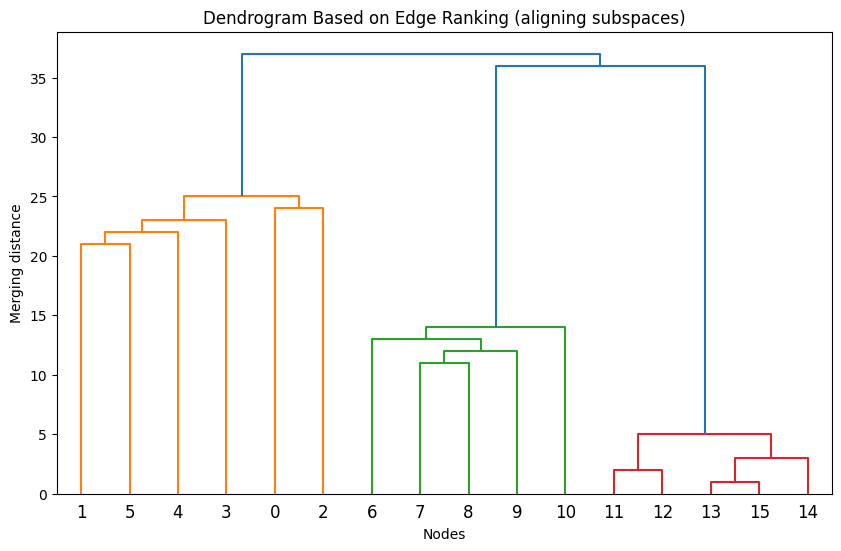

In [54]:
# Step 1: Define nodes and ranked edges
num_points = 16
nodes = list(range(num_points))
checks = []

# Step 2: Build the linkage matrix
clusters = {i: [i] for i in nodes}  # Each node starts as its own cluster
linkage_matrix = []
next_cluster_id = num_points

for i, edge in enumerate(edges):
    node1, node2 = edge

    # Find clusters for the nodes
    cluster1 = [k for k, v in clusters.items() if node1 in v][0]
    cluster2 = [k for k, v in clusters.items() if node2 in v][0]

    # Merge clusters if they are distinct
    if cluster1 != cluster2:
        new_cluster = clusters[cluster1] + clusters[cluster2]
        del clusters[cluster1]
        del clusters[cluster2]
        clusters[next_cluster_id] = new_cluster
        checks.append(i)

        # Add to linkage matrix: [cluster1, cluster2, edge_index, new_cluster_size]
        linkage_matrix.append([float(cluster1), float(cluster2), float(i + 1), float(len(new_cluster))])
        next_cluster_id += 1

# Convert linkage matrix to numpy array
linkage_matrix = np.array(linkage_matrix)

# Step 3: Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=np.arange(num_points))
plt.title("Dendrogram Based on Edge Ranking (aligning subspaces)")
plt.xlabel("Nodes")
plt.ylabel("Merging distance")
plt.show()

In [54]:
class SyntheticSignals:
    def __init__(self, basis, V, d, seed, snaps, SS = None):
        '''
        A class for generating possibly noisy signals with a covariance structure lying on different linear subspaces
        Attributes:
            V: int ->               Number of nodes
            d: int ->               Nodes stalks dimension
            SNR: float ->           Signal-to-noise ratio (db)
            seed: int ->            Random seed for reproducibility
            snaps: int ->           Number of signals observed in each subspace
        Methods:
            subpaceAssignment       Randomly assign to each node a linear subspace of R^d with dimension sampled uniformly at random between 1 and d
            random_crosscov         Generates a random crosscovariance matrix with a specific block-sparsity pattern
            random_coefficients     Generates gaussian distributed coefficients for the sparse construction of signals 
            noise                   Generates noise with a given SNR
            normalize               Performs L2 normalization 
            signals_generation      Generates signals accordingly to precomputed basis and spectrum 
        '''

        self.basis = basis
        self.V = V
        self.d = d
        self.seed = seed
        self.snaps = snaps
        self.generated = False
        
        self.subspace_assignment(SS)
        self.random_crosscov()
        self.random_coefficients()
                
    def subspace_assignment(self, SS):
        if SS is None:
            self.SS = {v: np.random.choice(self.d, np.random.choice(np.arange(1,self.d), 1), replace = False) for v in range(self.V)}
            self.dims = {v:len(self.SS[v]) for v in range(self.V)}
        else:
            self.SS = SS
            self.dims = {v:len(self.SS[v]) for v in range(self.V)}

    def random_crosscov(self, scale = 10):
        
        self.dim = np.sum(list(self.dims.values()))

        # Generate a random positive spectrum
        eigenvalues = np.random.exponential(scale, self.dim)

        # Use QR decomposition on a matrix with random entries to get an orthonormal basis
        Q, _ = np.linalg.qr(np.random.randn(self.dim, self.dim))

        # Build a covariance matrix using the computed spectrum and orthonormal basis

        self.C = Q @ np.diag(eigenvalues) @ Q.T
        '''
        self.Cs = {(u,v): None for (u,v) in list(combinations(range(self.V),2))}

        # Map all the blocks of the covariance matrix for further operations
        start_i = 0
        for i, di in list(self.dims.items()):
            start_j = start_i + di  # Upper triangular starts after the diagonal block
            for j, dj in list(self.dims.items())[i+1:]:
                end_i = start_i + di
                end_j = start_j + dj
                self.Cs[(i,j)] = self.C[start_i:end_i, start_j:end_j]
                start_j = end_j
            start_i += di
        '''

    def random_coefficients(self):
        
        # Generate a stack of all the coefficients leveraging the imposed covariance structure
        self.S = self.C @ np.random.randn(self.dim, self.snaps)

        # Map back all the coefficients ot each node
        self.coeffs = {v: None for v in range(self.V)}
        start = 0
        for v in range(self.V):
            end = start + self.dims[v]
            self.coeffs[v] = self.S[start:end, :]
            start = end
    
    def noise(self, signal, SNR):

        if SNR is None:
            return np.zeros_like(signal)

        signal_power = np.mean(np.square(signal), axis=0, keepdims=True)
        snr_linear = 10 ** (SNR / 10)
        noise_power = signal_power / snr_linear

        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
        return noise
    
    
    def normalize(self, signal):

        return signal / np.linalg.norm(signal, axis=0)
    
    def signals_generation(self, SNR):
        
        # Finally we leverage the structure we impose to generate signals
        np.random.seed(self.seed)
        self.signals = {
            node: (
                signal := (self.basis[:,self.SS[node]] @ self.coeffs[node]))
             + self.noise(signal, SNR)
            for node in range(self.V)
        }

        self.generated = True
    
    def sparse_coder(self, alpha):

        def prox21_col(x):
                
            return ( 1 - alpha / (np.max([np.linalg.norm(x), alpha])) ) * x
        
        def prox21(X):

            X = np.apply_along_axis(prox21_col, axis = 1, arr = X)
            return X

        def ProxGradDescent(node, LR = 3e-3, MAXITER = 1000, eps = 1e-2):
            S = np.zeros((self.d, self.snaps))
            loss = np.inf

            for _ in range(MAXITER):
                # Gradient update: x_new = x_old + step_size * D^T (y - D * x_old)
                gradient = self.basis.T @ self.basis @ S - self.basis.T @ self.signals[node]
                S = S - LR * gradient
                
                # Hard thresholding: keep only the k largest entries
                S = prox21(S)
                
                temp = np.linalg.norm(self.signals[node] - self.basis @ S)
                if loss - temp < eps:
                    break
                else:
                    loss = temp
            return S
        
        if self.generated:
            coder = {v: np.zeros((self.d, self.snaps)) for v in range(self.V)}
            for node in range(self.V):
                coder[node] = ProxGradDescent(node)
            return coder
        else:
            return 'Before sparsifying you should generate signals :)'

In [89]:
# Datadriven alignment

V = 16
d = 64
B = dct(np.eye(d), axis=0, norm='ortho').T

dims = {
    v: 40*(8 <= v <= 16) + 10*(v < 8) for v in range(V)
}

SS = {v: np.random.choice(d, dims[v], replace = False) for v in range(V)}
X = SyntheticSignals(B, V, d, 42, 10, SS)
G = DataDrivenGrassmanGraph(V, d, X, B, 42)
G.alignment()

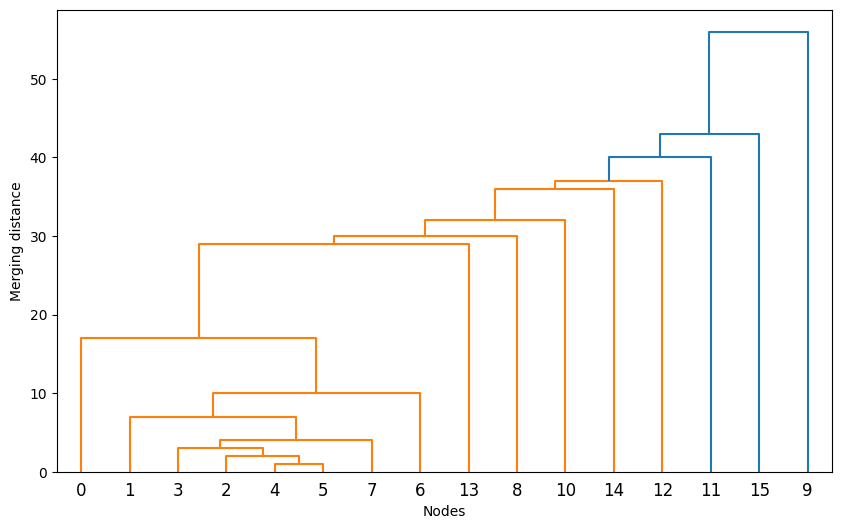

In [90]:
edges_without_alignment = [(edge[0][0],edge[0][1]) for edge in G.inference()['Pre']]

num_points = V
nodes = list(range(num_points))
checks_without_alignment = []

clusters = {i: [i] for i in nodes}  
linkage_matrix = []
next_cluster_id = num_points

for i, edge in enumerate(edges_without_alignment):
    node1, node2 = edge

    cluster1 = [k for k, v in clusters.items() if node1 in v][0]
    cluster2 = [k for k, v in clusters.items() if node2 in v][0]

    if cluster1 != cluster2:
        new_cluster = clusters[cluster1] + clusters[cluster2]
        del clusters[cluster1]
        del clusters[cluster2]
        clusters[next_cluster_id] = new_cluster
        checks_without_alignment.append(i)

        linkage_matrix.append([float(cluster1), float(cluster2), float(i + 1), float(len(new_cluster))])
        next_cluster_id += 1

linkage_matrix = np.array(linkage_matrix)

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=np.arange(num_points))
plt.title("")
plt.xlabel("Nodes")
plt.ylabel("Merging distance")
plt.show()

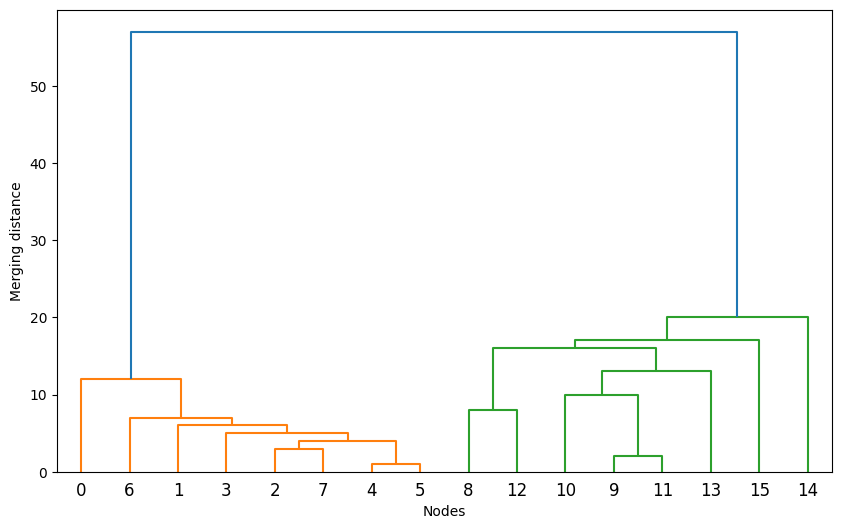

In [91]:
edges_with_alignment = [(edge[0][0],edge[0][1]) for edge in G.inference()['Post']]

num_points = V
nodes = list(range(num_points))
checks_with_alignment = []

clusters = {i: [i] for i in nodes}  
linkage_matrix = []
next_cluster_id = num_points

for i, edge in enumerate(edges_with_alignment):
    node1, node2 = edge

    cluster1 = [k for k, v in clusters.items() if node1 in v][0]
    cluster2 = [k for k, v in clusters.items() if node2 in v][0]

    if cluster1 != cluster2:
        new_cluster = clusters[cluster1] + clusters[cluster2]
        del clusters[cluster1]
        del clusters[cluster2]
        clusters[next_cluster_id] = new_cluster
        checks_with_alignment.append(i)

        linkage_matrix.append([float(cluster1), float(cluster2), float(i + 1), float(len(new_cluster))])
        next_cluster_id += 1

linkage_matrix = np.array(linkage_matrix)

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=np.arange(num_points))
plt.title("")
plt.xlabel("Nodes")
plt.ylabel("Merging distance")
plt.show()

In [93]:
edges_subset_without = edges_without_alignment[:checks_without_alignment[-1]+1]
edges_subset_with = edges_with_alignment[:checks_with_alignment[-1]+1]

In [119]:
len(edges_subset_without)

56

In [120]:
len(edges_subset_with)

57

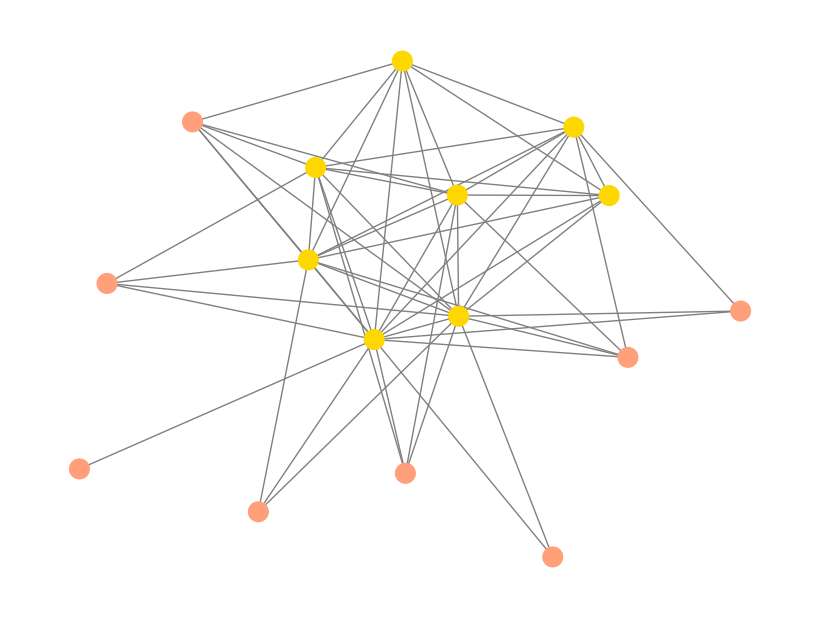

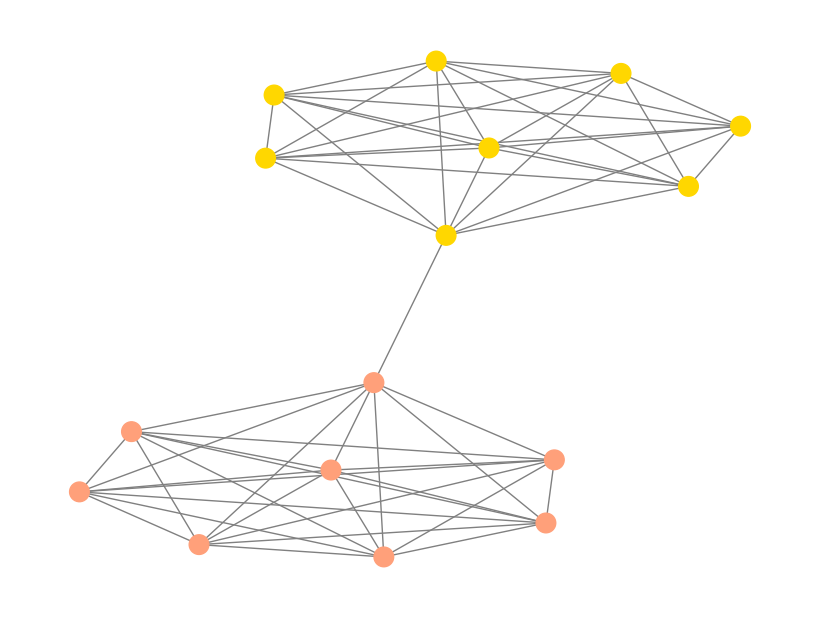

In [ ]:

# Create Graph 1 and Graph 2
G1 = nx.Graph()
G1.add_nodes_from(range(V))
G1.add_edges_from(edges_subset_without)

G2 = nx.Graph()
G2.add_nodes_from(range(V))
G2.add_edges_from(edges_subset_with)

# Create node labels and colors
node_labels = {v: (0 if dims[v] == 10 else 1) for v in range(V)}
node_colors = ['gold']*8 + ['lightsalmon']*8

# Plot the first graph with the best layout (spring layout)
plt.figure(figsize=(8, 6))
pos_G1 = nx.kamada_kawai_layout(G1)  # Spring layout for G1
nx.draw(G1, pos=pos_G1, with_labels=False, node_color=node_colors, 
        cmap=plt.cm.bwr, node_size=200, edge_color='grey')
plt.show()

# Plot the second graph with the best layout (spring layout)
plt.figure(figsize=(8, 6))
pos_G2 = nx.kamada_kawai_layout(G2) # Spring layout for G2
nx.draw(G2, pos=pos_G2, with_labels=False, node_color=node_colors, 
        cmap=plt.cm.bwr, node_size=200, edge_color='grey')
plt.show()


______

# Identifying the graph

In [8]:
X

In [11]:
d = 16
V = 16
basis = dct(np.eye(d), axis=0, norm='ortho').T

X = SyntheticSignals(basis, V, d, 42, 1000)

G = DataDrivenGrassmanGraph(V, d, X, basis, 42)
G.alignment()

In [12]:
edges = [(edge[0][0], edge[0][1]) for edge in G.inference()['Post']]

In [14]:
E0 = 70

B = np.zeros((d*E0, d*V))

for i, edge in enumerate(edges[:E0]):
    B[i*d:(i+1)*d, edge[0]*d:(edge[0]+1)*d] = G.Fs[edge][edge[0]]
    B[i*d:(i+1)*d, edge[1]*d:(edge[1]+1)*d] = - G.Fs[edge][edge[1]]

L = B.T @ B

In [15]:
def RandomSheafSignal(N, V, d, L_f, noisy = False, SNR = None):
    def noise(signal, SNR):

        if SNR is None:
            return np.zeros_like(signal)

        signal_power = np.mean(np.square(signal), axis=0, keepdims=True)
        snr_linear = 10 ** (SNR / 10)
        noise_power = signal_power / snr_linear

        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
        return noise
    
    X = np.random.randn(V*d,N)

    # Tikhonov regularization step
    Lambda, U = np.linalg.eig(L_f)
    H = 1/(1 + 10*Lambda)
    Y = U @ np.diag(H) @ U.T @ X

    Y = np.apply_along_axis(lambda x: x / np.linalg.norm(x), 0, Y)

    if noisy:
        
        Y += noise(Y, SNR)

    return Y

In [16]:
Y = RandomSheafSignal(1000, V, d, L, True, 10)

In [17]:
signals = {
    v: Y[v*d:(v+1)*d,:] for v in range(V)
}

In [18]:
signals[0].shape

(16, 1000)

In [19]:
def sparse_coder(V, d, snaps, signals, basis, alpha):

    def prox21_col(x):
            
        return ( 1 - alpha / (np.max([np.linalg.norm(x), alpha])) ) * x
    
    def prox21(X):

        X = np.apply_along_axis(prox21_col, axis = 1, arr = X)
        return X

    def ProxGradDescent(node, LR = 3e-3, MAXITER = 1000, eps = 1e-2):
        S = np.zeros((d, snaps))
        loss = np.inf

        for _ in range(MAXITER):
            # Gradient update: x_new = x_old + step_size * D^T (y - D * x_old)
            gradient = basis.T @ basis @ S - basis.T @ signals[node]
            S = S - LR * gradient
            
            # Hard thresholding: keep only the k largest entries
            S = prox21(S)
            
            temp = np.linalg.norm(signals[node] - basis @ S)
            if loss - temp < eps:
                break
            else:
                loss = temp
        return S
    
    coder = {v: np.zeros((d, snaps)) for v in range(V)}
    for node in range(V):
        coder[node] = ProxGradDescent(node)
    return coder

In [20]:
codebook = sparse_coder(V, d, 1000, signals, basis, 0.001)

In [51]:
class DataDrivenGrassmanGraph:
    def __init__(
            self, 
            V, 
            d,
            basis,
            seed,
            X = None
    ):
        '''
        This class should implement the same idea of subspace alignment 
        but through a data-driven apoproach, i.e. using observed signals and not basis for subspaces (still under modeling phase)
        Attributes:
            V: int ->               Number of nodes
            d: int ->               Nodes stalks dimension
            X: SyntheticSignals ->  An instantiated object of the SyntheticSignals class
            seed: int ->            Random seed for reproducibility
            mode: str ->            Mode for the generation of the graph, 
                                    either "boolean" if based on cardinality constrained programming 
                                    or "geometric" if based on thresholding the post-alignemnt distance
            tau: float ->           Threshold for the geometric graph
        Methods:
            Procrustes              Compute the orthogonal Procrustes solution to the data-driven alignment problem ||F_u X_u - F_v X_v||_F^2
            alignment               Perform the alignment between each pair of subspaces
            inference               Carries out a graph based on one of the two mode as a set of edges
        '''

        self.V = V
        self.d = d

        self.X = X
        self.basis = basis
  
        self.seed = seed

    def Procrustes(self, u, v, codebook = None):
        if codebook is None:
            S_u = self.X.coeffs[u]
            S_v = self.X.coeffs[v]
            D_u = self.basis[:,self.X.SS[u]]
            D_v = self.basis[:,self.X.SS[v]]
            
        else:
            S_u = codebook[u]
            S_v = codebook[v]
            D_u = self.basis
            D_v = self.basis
            
        # We use the empirical cross covariance
        C_uv = S_u @ S_v.T / self.X.snaps

        X, _, Y = np.linalg.svd(D_u @ C_uv @ D_v.T, full_matrices=False)
        F_u = Y.T @ X.T
        F_v = np.eye(self.d)

        return F_u, F_v, D_u @ S_u, D_v @ S_v
    
    def alignment(self, codebook = None):
        
        self.pre_dists = {}
        self.post_dists = {}
        self.Fs = {edge: {
                    edge[0]: None, 
                    edge[1]: None
                } for edge in list(combinations(range(self.V), 2))}
                
        self.dims_diff = {}
        
        for (u,v) in list(combinations(range(self.V), 2)):
            F_u, F_v, S_u, S_v = self.Procrustes(u, v, codebook)
            self.pre_dists[(u,v)] = np.linalg.norm(S_u - S_v) ** 2 / self.X.snaps
            self.post_dists[(u,v)] = np.linalg.norm(F_u @ S_u - F_v @ S_v) ** 2 / self.X.snaps
            self.Fs[(u,v)][u] = F_u
            self.Fs[(u,v)][v] = F_v
            self.dims_diff[(u,v)] = np.abs(len(self.X.SS[u]) - len(self.X.SS[v]))
            
    def inference(self):
        
        return {
            'Pre': list(sorted(self.pre_dists.items(), key=lambda x:x[1])),
            'Post': list(sorted(self.post_dists.items(), key=lambda x:x[1]))
        }


In [22]:
G = DataDrivenGrassmanGraph(V, d, B, 42, X)

In [24]:
codebook[0].shape

(16, 1000)

In [ ]:
G.alignment(codebook)